This code models the movement of two servos one over the other, so that we can recover the true direction of the laser mounted on the second axis. Notice that this is different from a laser with two degrees of freedom located in at the origin of the world coordinates

In [38]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import cv2

import sys
sys.path.append('../')
from libs.cam_calib_utils import inv_svd


interactive(children=(IntSlider(value=0, description='elev', max=90, min=-90, step=5), IntSlider(value=0, desc…

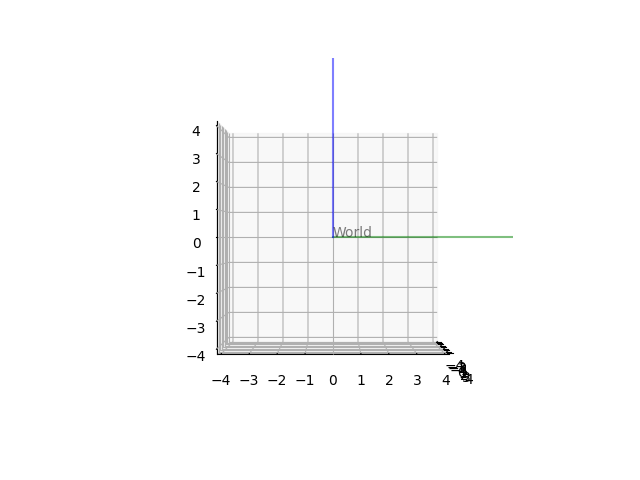

In [39]:
def plot_coord_sys(M_world_sys, scale, sys_name, ax, alpha):
    # Define axes in sys-coord_system
    xyz_s = np.array([[0, 0, 0],[scale, 0, 0], [0, 0, 0],[0, scale, 0], [0, 0, 0],[0, 0, scale]]).T

    # prepare to plot: homogeneous coords:
    xyz1_s = np.row_stack((xyz_s,np.ones((1,xyz_s.shape[1]))))

    # convert to world coords:
    xyz1_w = M_world_sys.dot(xyz1_s)

    # plot axes: x->red, y->green, z->blue.
    ax.plot(xyz1_w[0,:2], xyz1_w[1,:2], xyz1_w[2,:2], color='red', alpha=alpha)
    ax.plot(xyz1_w[0,2:4], xyz1_w[1,2:4], xyz1_w[2,2:4], color='green', alpha=alpha)
    ax.plot(xyz1_w[0,4:], xyz1_w[1,4:], xyz1_w[2,4:], color='blue', alpha=alpha)
    ax.text(xyz1_w[0,0], xyz1_w[1,0], xyz1_w[2,0], sys_name, 'x', color='black', alpha=alpha)
    
def make_figure(x_lim, y_lim, z_lim):
    ax = plt.figure().add_subplot(projection='3d')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_zlim(z_lim)
    plt.gca().set_aspect('equal', adjustable='box')
    return ax

# test transformation matrix:
M_world = np.eye(4)
    
# define figure:
# plot the rotated coordinate system:
ax = make_figure([-4,4], [-4,4], [-4,4])
@widgets.interact(elev=(-90, 90, 5), azim=(-90, 90, 5))
def update(elev = 0, azim=0):
    [l.remove() for l in ax.lines]
    [t.remove() for t in ax.texts]
    plot_coord_sys(M_world,10,'World', ax, 0.5)
    ax.view_init(elev=elev, azim=azim)

#plt.show()

Now we define the Laser base coordinate system:

M_L_W
[[1.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 10.000]
 [0.000 -1.000 0.000 0.000]
 [0.000 0.000 -0.000 1.000]]
M_W_L
[[1.000 0.000 0.000 0.000]
 [0.000 0.000 -1.000 0.000]
 [0.000 1.000 0.000 -10.000]
 [0.000 0.000 0.000 1.000]]


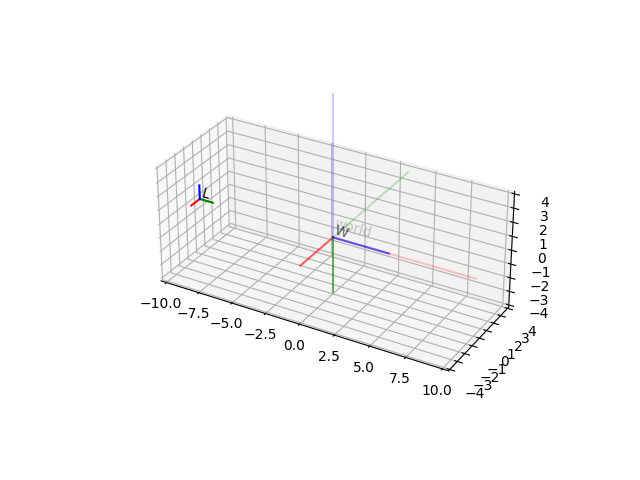

In [40]:
# M_world, M_W=>(wall), M_L=>(laser)

# M_W: wall:
M_W_world = np.eye(4)
M_W_world[:3,:3] = np.array([[0,-1,0],[0,0,-1],[1,0,0]])
M_W_world[:3,3,None] = np.array([[0,0,0]]).T
M_world_W = inv_svd(M_W_world)

# M_L: laser: (All info is given with respect to target coordinates)
angles2W_true = np.array([90,0,0])
#angles2W_true = np.array([ang_x,ang_y,ang_z]) 
T_true_W = np.array([[0,0,-10]]).T
R_true_W_L,_ = cv2.Rodrigues(np.deg2rad(angles2W_true))

M_W_L = np.eye(4)
M_W_L[:3,:3] = R_true_W_L
M_W_L[:3,3,None] = T_true_W
M_L_W = inv_svd(M_W_L)

M_world_L = M_world_W.dot(M_W_L)


# define figure:
ax = make_figure([-10,10], [-4,4], [-4,4])
plot_coord_sys(M_world,10,'world', ax, 0.2)
plot_coord_sys(M_world_W,4,'W', ax, 0.6)
plot_coord_sys(M_world_L,1,'L', ax, 1)
    

#plt.show()
print('M_L_W')
print(M_L_W)
print('M_W_L')
print(M_W_L)

interactive(children=(IntSlider(value=0, description='theta_deg', max=90, min=-90, step=5), IntSlider(value=0,…

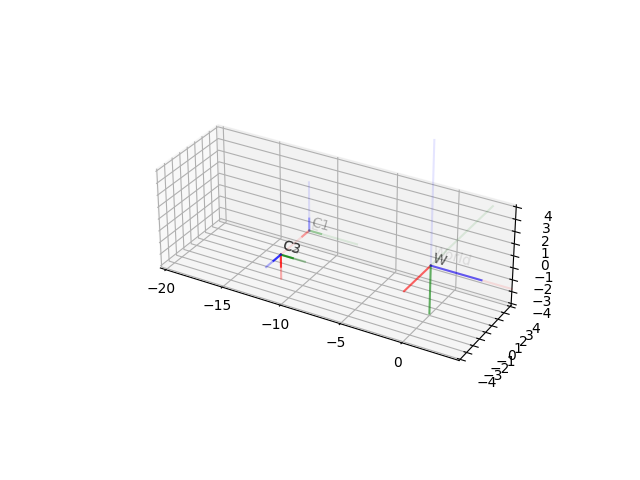

In [41]:
# define figure:
ax = make_figure([-20,4], [-4,4], [-4,4])


def make_C1(theta_deg):
    M_L_C1 = np.eye(4)
    M_L_C1[:3,:3], _ = cv2.Rodrigues(np.array([0,0,np.deg2rad(theta_deg)]))
    return M_L_C1

def make_C2(Lx):
    M_C1_C2 = np.eye(4)
    #R
    M_C1_C2[:3,:3] = np.array([[0,0,-1],[0,1,0],[1,0,0]]).T
    
    #T
    M_C1_C2[:3,3] = np.array([Lx,0,0])
    return M_C1_C2

def make_C3(phi_deg):
    M_C2_C3 = np.eye(4)
    M_C2_C3[:3,:3], _ = cv2.Rodrigues(np.array([0,0,np.deg2rad(phi_deg)]))
    return M_C2_C3

def move_set_up(theta_deg, phi_deg, M_W_L, Lx):
    # update C1 coordinate sys and compute M to the world
    M_L_C1 = make_C1(theta_deg)
    M_W_C1 = M_W_L.dot(M_L_C1)

    # update C2 coordinate sys and compute M to the world
    M_C1_C2 = make_C2(Lx=Lx)
    M_W_C2 = M_W_C1.dot(M_C1_C2)

    # update C3 coordinate sys and compute M to the world
    M_C2_C3 = make_C3(phi_deg)
    M_W_C3 = M_W_C2.dot(M_C2_C3)

    return M_W_C1, M_W_C2, M_W_C3


Lx=4.0

# plot the rotated coordinate system:
@widgets.interact(theta_deg=(-90, 90, 5), phi_deg=(-90, 90, 5))
def update(theta_deg = 0, phi_deg=0):
    [l.remove() for l in ax.lines]
    [t.remove() for t in ax.texts]
    
    # update movement:
    M_W_C1, M_W_C2, M_W_C3 = move_set_up(theta_deg, phi_deg, M_W_L, Lx=Lx)
    
    # -------------------------------
    plot_coord_sys(np.eye(4),10,'World', ax, 0.1)
    plot_coord_sys(M_world_W,4,'W', ax, 0.6)
    # plot
    plot_coord_sys(M_world_W.dot(M_W_L),4,'L', ax, 0.1)
    plot_coord_sys(M_world_W.dot(M_W_C1),1,'C1', ax, 0.3)
    plot_coord_sys(M_world_W.dot(M_W_C2),2,'C2', ax, 0.3)
    plot_coord_sys(M_world_W.dot(M_W_C3),1,'C3', ax, 0.7)

# Collection data for calibration (Test)

In [42]:
import sys
sys.path.append('../')
from libs.cam_calib_utils import inv_svd

# We'll find theta and deg (that we directly measure- but here we need to calculate), with optimization.
# Since the calculation is complicated.
def find_theta_phi_deg(theta_phi_deg, P1_L, U1_C3):
    theta_deg = theta_phi_deg[0]
    phi_deg = theta_phi_deg[1]
    _, _, M_L_C3 = move_set_up(theta_deg, phi_deg, M_W_L=np.eye(4),Lx=Lx) # M_W_L=I so that we go until Laser-Based coordinates
    M_C3_L = inv_svd(M_L_C3)

    # convert P_L to C3 coords:
    P1_C3 = M_C3_L.dot(P1_L)
    U1_C3_hat = P1_C3/np.sqrt(np.sum(P1_C3[:3]**2,axis=0,keepdims=True))
    U1_C3_hat[3] = 1

    error = np.mean(np.sum((U1_C3 - U1_C3_hat)**2,axis=0,keepdims=True), axis=1, keepdims=True)
    return error

theta_phi_deg = [0,0]
P1_L = np.array([[1,1,1,1]]).T
U1_C3 = np.array([[0,0,1,1]]).T
err = find_theta_phi_deg(theta_phi_deg,P1_L, U1_C3)
print(err)

[[3.809]]


In [43]:
# define world points Pw:
P_W = np.array([[0,0,0], [0,-1,0],[0,-2,0],[1,0,0],[1,-1,0],[1,-2,0]]).T
P_W = P_W*4
P1_W = np.row_stack((P_W,np.ones((1,P_W.shape[1]))))
P1_world = M_world_W.dot(P1_W)

# convert P1_W to Laser base coords:
P1_L = M_L_W.dot(P1_W)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(P1_W,end="\n---\n")
print(P1_L,end="\n---\n")


[[0.000 0.000 0.000 4.000 4.000 4.000]
 [0.000 -4.000 -8.000 0.000 -4.000 -8.000]
 [0.000 0.000 0.000 0.000 0.000 0.000]
 [1.000 1.000 1.000 1.000 1.000 1.000]]
---
[[0.000 0.000 0.000 4.000 4.000 4.000]
 [10.000 10.000 10.000 10.000 10.000 10.000]
 [0.000 4.000 8.000 0.000 4.000 8.000]
 [1.000 1.000 1.000 1.000 1.000 1.000]]
---


In [44]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

# find the angles theta and phi with optimization
x0mins = [-90,-90]
x0max =  [ 90, 90]
bounds = Bounds(x0mins, x0max)
U1_C3 = np.array([[0,1,0,1]]).T

theta_phi_results = []
for p_idx in range(P1_L.shape[1]):
    theta_phi_deg_0 = np.array([0,0])
    res = minimize(find_theta_phi_deg,theta_phi_deg_0,args=(P1_L[:,p_idx,None],U1_C3),method='nelder-mead', tol=1e-10, 
                   bounds=bounds,options={'maxiter':1e4, 'disp':True})
    theta_phi_results.append((res.x))

print(P1_W,end="\n---\n")
print(theta_phi_results)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 125
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 133
         Function evaluations: 257
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 139
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 44
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 138
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 146
         Function evaluations: 277
[[0.000 0.000 0.000 4.000 4.000 4.000]
 [0.000 -4.000 -8.000 0.000 -4.000 -8.000]
 [0.000 0.000 0.000 0.000 0.000 0.000]
 [1.000 1.000 1.000 1.000 1.000 1.000]]
-

C:\Users\evert\AppData\Local\Temp\ipykernel_18332\1317487483.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  ax = plt.figure().add_subplot(projection='3d')


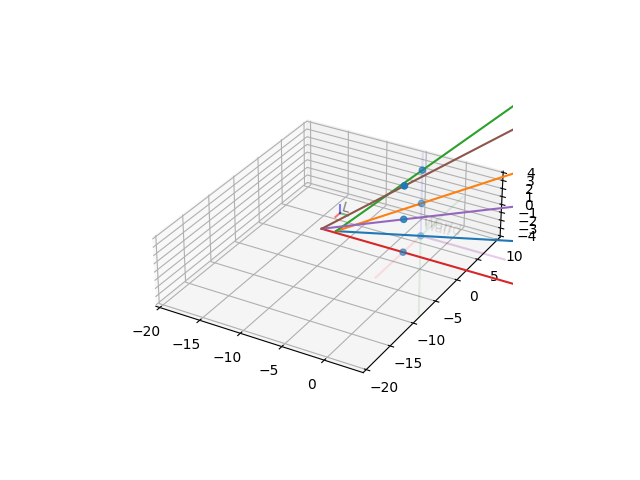

In [45]:
# plot world and points in world coords:
ax = make_figure([-20,4], [-20,10], [-4,4])
plot_coord_sys(M_world,10,'World', ax, 0.1)
plot_coord_sys(M_world_W,10,'Wall', ax, 0.1)
plot_coord_sys(M_world_W.dot(M_W_L),1,'L', ax, 0.5)
ax.scatter(P1_world[0,:],P1_world[1,:],P1_world[2,:])

M_L_C3_list = []
for idx, theta_phi_deg in enumerate(theta_phi_results):
    theta_deg = theta_phi_deg[0]
    phi_deg = theta_phi_deg[1]
    
    _, _, M_L_C3 = move_set_up(theta_deg, phi_deg, M_W_L=np.eye(4),Lx=Lx)
    M_L_C3_list.append(M_L_C3)

    M_W_C1, M_W_C2, M_W_C3 = move_set_up(theta_deg, phi_deg, M_W_L=M_W_L,Lx=Lx)
    q_W = M_W_C3.dot(np.array([[0,0,0,1]]).T)
    u_W = M_W_C3.dot(np.array([[0,1,0,1]]).T)
    f_W = q_W + 50*(u_W-q_W)

    # transform to plot in world:
    q_world = M_world_W.dot(q_W)
    f_world = M_world_W.dot(f_W)

    ax.plot([q_world[0], f_world[0]],[q_world[1], f_world[1]],[q_world[2], f_world[2]])


# Estimate R and T from measurements:

Given data:
- P1_W
- theta_deg, phi_deg
- Initial estimate of T based on T_cam

In [46]:
# 
def find_laser_base_R_T(ang_and_T, P1_W, M_L_C3_list):
    # convert P1_W to Laser coords.
    angles_hat = np.array(ang_and_T[0:3])
    T_hat = np.array(ang_and_T[3:])
    R_hat,_ = cv2.Rodrigues(np.deg2rad(angles_hat))

    M_L_W_hat = np.eye(4)
    M_L_W_hat[:3,:3] = R_hat
    M_L_W_hat[:3, 3] = T_hat

    P1_L_hat = M_L_W_hat.dot(P1_W)

    # Each point
    P1_L = np.zeros_like(P1_L_hat)
    for idx, M_L_C3 in enumerate(M_L_C3_list):
        q_L_i = M_L_C3.dot(np.array([[0,0,0,1]]).T)
        rho_i = np.sqrt(np.sum((P1_L_hat[:3,idx] - q_L_i[:3,0])**2,axis=0))
        P1_L[:,idx,None] = M_L_C3.dot(np.array([[0,rho_i,0,1]]).T)
    
    error = np.mean(np.sum((P1_L - P1_L_hat)**2,axis=0,keepdims=True), axis=1, keepdims=True)
    return error

ang_and_T = [0,0,0,  0,0,0]
P1_W = P1_W
M_L_C3_list = M_L_C3_list
err = find_laser_base_R_T(ang_and_T, P1_W, M_L_C3_list)
print(err)

[[130.161]]


In [57]:
x0mins = [-90,-90,-90,   -100,-100,-100]
x0max =  [ 90, 90, 90,    100, 100, 100]
bounds = Bounds(x0mins, x0max)


ang_and_T0 = np.random.uniform(-80,80,6)
ang_and_T0[3:] = np.array([0,11,1])

res = minimize(find_laser_base_R_T,ang_and_T0,args=(P1_W, M_L_C3_list),method='nelder-mead', tol=1e-10, 
               bounds=bounds,options={'maxiter':1e4, 'disp':True})

angles_hat = np.array(res.x[0:3])
T_hat = np.array(res.x[3:])
R_hat,_ = cv2.Rodrigues(np.deg2rad(angles_hat))

M_L_W_hat = np.eye(4)
M_L_W_hat[:3,:3] = R_hat
M_L_W_hat[:3, 3] = T_hat # This T_hat is with respect to the Laser coords.

print('x0')
print(ang_and_T0)
print('angles_2Wall_true',angles2W_true, T_true_W.T)
print(res.x)
print('hat M_L_W_hat')
print(M_L_W_hat)
print('true M_L_W')
print(M_L_W)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1046
         Function evaluations: 1618
x0
[-19.731 79.381 -59.607 0.000 11.000 1.000]
angles_2Wall_true [90  0  0] [[  0   0 -10]]
[-90.000 0.000 -0.000 0.000 10.000 -0.000]
hat M_L_W_hat
[[1.000 -0.000 0.000 0.000]
 [-0.000 0.000 1.000 10.000]
 [-0.000 -1.000 0.000 -0.000]
 [0.000 0.000 0.000 1.000]]
true M_L_W
[[1.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 10.000]
 [0.000 -1.000 0.000 0.000]
 [0.000 0.000 -0.000 1.000]]
